# Exploration Data
This notebook shows data exploration to build a model (or several) in order to classify housing assistance requests thanks to the given datasets.

This is a multi-class classification task

The metric to optimize and the datasets description are explained in DS_technical_test_tutorial.ipynb Jupyter Notebook.

## import

In [324]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)


import numpy as np
import pandas as pd

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix

## Definition

## Useful functions

In [157]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)


def display_missing(df):
    '''
    Function to display missing values into dataframe.
    Creates a barplots figure and outputs values.

    - input : 
        df : dataframe : data to check
    - output : 
        df_missing : dataframe : table of missing values
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing


def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=7, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
def plot_cont(X,Y,data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
    cont = c.copy()

    tx = data[X].value_counts()
    ty = data[Y].value_counts()

    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    cont

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n

    c = c.fillna(0) # on remplace les valeurs nulles par des 0
    mesure = (c-indep)**2/indep
    xi_n = mesure.sum().sum()
    # plot
    fig = plt.figure(figsize = (5,11.75))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f")
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

## Load raw data

In [163]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN


In [164]:
individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
0,130667d2964de43c511d0ead7ac66b33,b24a8cfaaf3663bac45ca3bcd24f0b36,20,on the street,5,1977,NaN,NaN,male,2018-01-29,isolated person,30,isolated adult,10,single person,f
1,b1cd62fcf24eebb0f685d5eaf55317a8,eef783d1bda82661a751c12c34aff8c2,20,on the street,5,1980,NaN,NaN,male,2019-03-07,NaN,30,isolated adult,-1,NaN,f
2,12cc0a18890bd4959fe42df3ae58838e,927b6fa58d6be263c411332835b11fec,20,on the street,1,2003,NaN,NaN,male,2019-03-13,NaN,10,isolated underage/child,-1,NaN,f
3,ae2d5b4dc181d29e430132f145da1556,94181d5cf4a56cc84d12677df84e2e03,20,on the street,7,1986,NaN,NaN,female,2018-10-09,NaN,30,isolated adult,-1,NaN,f
4,d13a17ce36c832514fda2464e11c4a9f,e79d2e3f9ace50049f1796c098008c13,35,hotel paid by the emergency structure,9,1980,NaN,NaN,female,2017-06-22,husband/spouse,1,partner,-1,NaN,f


## Target : classes to predict

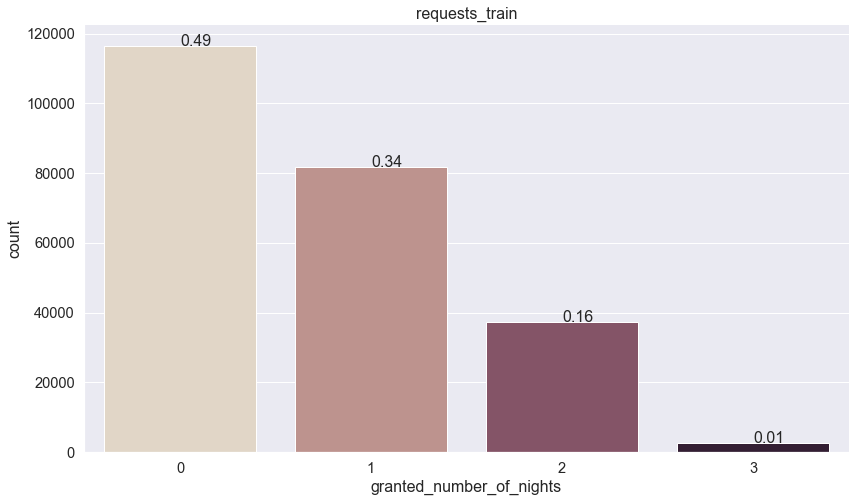

In [149]:
plot_hist_cat(x="granted_number_of_nights", data=requests_train, 
              title="requests_train")

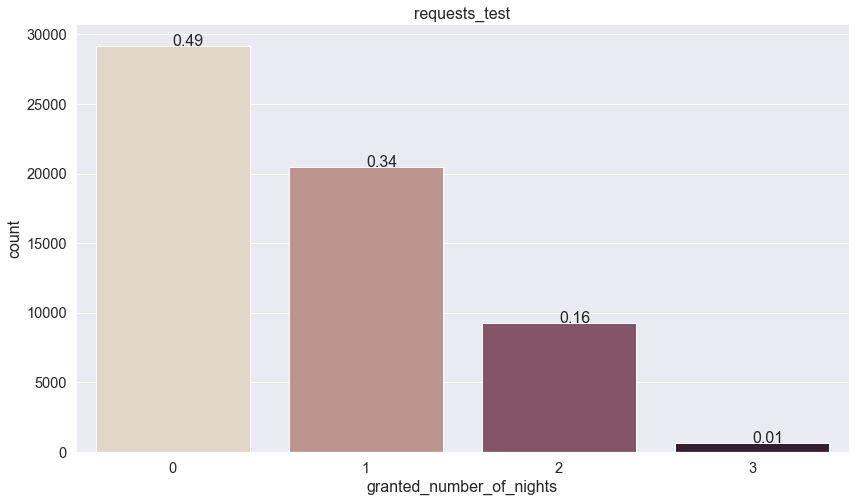

In [150]:
plot_hist_cat(x="granted_number_of_nights", data=requests_test, 
              title="requests_test")

OK => Same proportion in train and test data.

## Missing data

### requests_train

,nb_missing,ratio
request_id,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
housing_situation_id,0,0.000000
group_type,0,0.000000
victim_of_violence,0,0.000000
group_id,0,0.000000


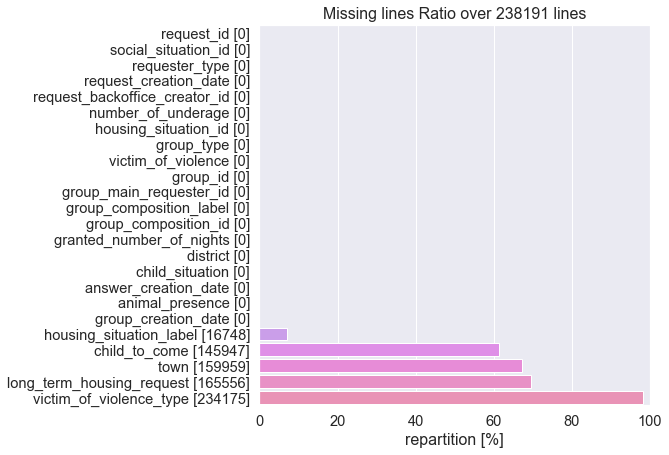

In [22]:
display_missing(requests_train)

In [207]:
requests_train.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,12cc0a18890bd4959fe42df3ae58838e,ae2d5b4dc181d29e430132f145da1556,d13a17ce36c832514fda2464e11c4a9f
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-01 21:00:00,2019-02-25 15:12:05.037,2019-02-20 09:59:20.603
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,unknown
district,85,85,59,50,93
granted_number_of_nights,1,1,1,2,2
group_composition_id,10,10,80,20,60
group_composition_label,man alone,man alone,isolated child/underage,woman alone,group with child(ren)
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-03-13 12:54:15.887,2018-10-09 14:37:29.773,2018-10-02 10:47:36.931


In [56]:
requests_train["housing_situation_label"].value_counts(dropna=False)

street                                         101885
emergency structure                             68512
hotel paid by the emergency centre              17052
NaN                                             16748
other                                            9340
accomodation by a third party                    9171
shelters                                         4238
mobile or makeshift shelter                      2832
public hospital                                  2170
personal or marital home                         1722
hotel paid by the household                       810
refused to answer                                 807
hotel paid by the regional administration         660
inclusion structure                               468
parental home                                     396
psychiatric hospital                              308
stabilisation structure                           298
hotel paid by an association                      269
religious place (church, mos

### requests_test

,nb_missing,ratio
request_id,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
housing_situation_id,0,0.000000
group_id,0,0.000000
group_main_requester_id,0,0.000000
group_composition_id,0,0.000000


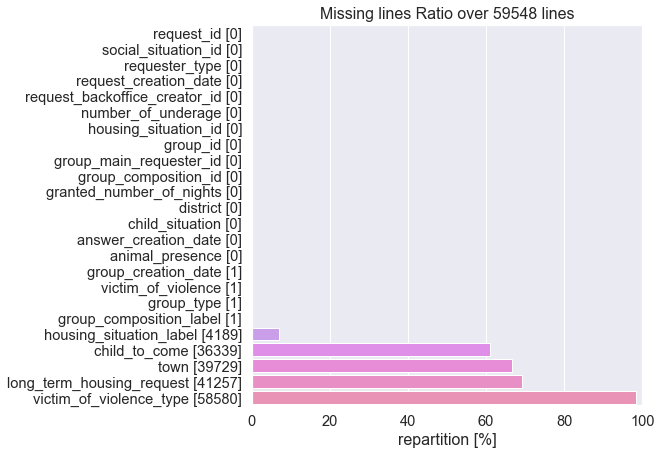

In [23]:
display_missing(requests_test)

### individuals_train

,nb_missing,ratio
request_id,0,0.000000
individual_id,0,0.000000
housing_situation_2_id,0,0.000000
housing_situation_2_label,0,0.000000
birth_month,0,0.000000
birth_year,0,0.000000
individual_role_2_id,0,0.000000
marital_status_id,0,0.000000
gender,1,0.000260
pregnancy,14,0.003645


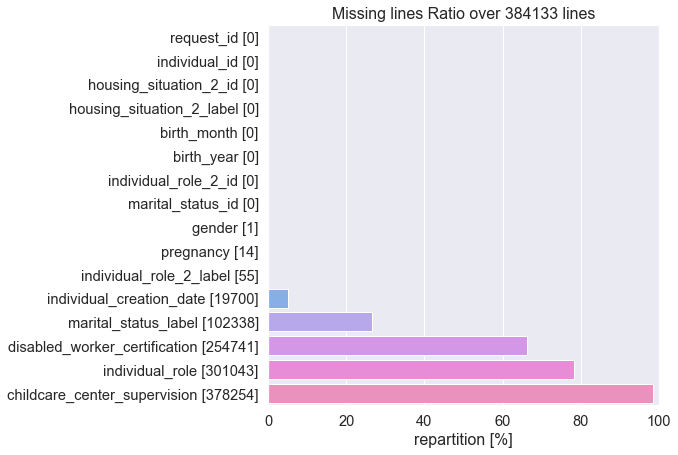

In [24]:
display_missing(individuals_train)

In [183]:
individuals_train.shape[0]

384133

In [182]:
individuals_train["request_id"].nunique()

238191

In [200]:
requests_train["request_id"].nunique()

238191

In [184]:
individuals_train["individual_id"].nunique()

83513

Several individuals for one request

And one individual can have multiple status (during time ?)

### individuals_test

,nb_missing,ratio
request_id,0,0.000000
individual_id,0,0.000000
housing_situation_2_id,0,0.000000
housing_situation_2_label,0,0.000000
birth_month,0,0.000000
birth_year,0,0.000000
individual_role_2_id,0,0.000000
marital_status_id,0,0.000000
gender,1,0.001046
pregnancy,4,0.004182


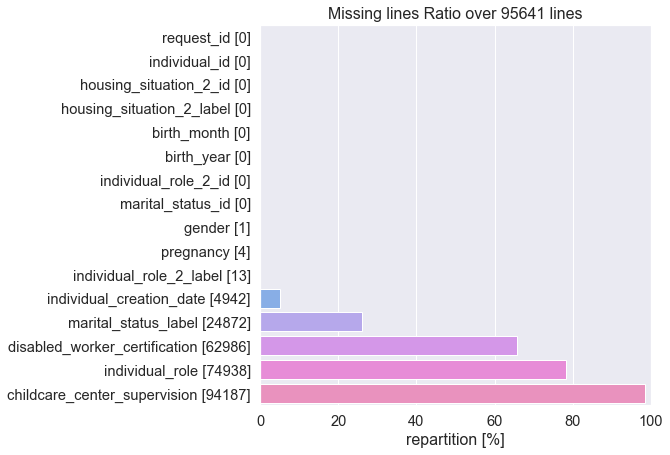

In [25]:
display_missing(individuals_test)

In [201]:
individuals_test.shape[0]

95641

In [202]:
individuals_test["request_id"].nunique()

59548

In [203]:
requests_test["request_id"].nunique()

59548

All request_id from requests_test are into individuals_test

In [204]:
individuals_test["individual_id"].nunique()

42915

## Correlations

### Correct housing_situation_label
Only label 170 is unkonwn => add a housing_situation_label = "unknown"


housing_situation_label have some impact on number of nights
So we must keep it and check Nan Value???

In [73]:
requests_train["housing_situation_id"].value_counts(dropna=False)

200    101885
10      68512
50      17052
170     16748
160      9340
120      9171
100      4238
110      2832
130      2170
80       1722
40        810
180       807
190       660
30        468
70        396
140       308
20        298
220       269
210       235
150       147
60         85
90         38
Name: housing_situation_id, dtype: int64

In [74]:
requests_train["housing_situation_id"].nunique()

22

In [75]:
requests_train["housing_situation_label"].nunique() 

21

In [77]:
requests_train[requests_train["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    16748
Name: housing_situation_id, dtype: int64

In [154]:
requests_test[requests_test["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    4189
Name: housing_situation_id, dtype: int64

In [160]:
requests_train[requests_train["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
18,e7f5a33909899231d96518842d115f23,f,2019-02-28 09:35:23.766,-1,NaN,64,0,10,man alone,2018-11-13 12:02:02.667,...,NaN,NaN,-1,2b34d48f97e14e49e1b153eb66644809,2019-02-28 09:35:23.766,user,495f0e10efffa704d9a6df257801f146,NaN,f,NaN
30,9223b74676220e533c31db6af6a94103,f,2019-02-28 18:14:35.252,-1,NaN,51,1,10,man alone,2019-02-18 20:16:56.112,...,NaN,NaN,-1,63e83fbbebdabecde1fe46696f811ed0,2019-02-28 18:14:35.252,user,94a8e9f8ededc41000b196c80df6d898,NaN,f,NaN
80,2d824ff45b8cdb87f2bc8e52ad97965f,f,2019-02-11 20:01:57.84,-1,NaN,51,0,10,man alone,2018-09-11 13:10:40.766,...,NaN,NaN,-1,63e83fbbebdabecde1fe46696f811ed0,2019-02-11 20:01:57.84,user,3e9d94a773736db14f13284fcfdcfa05,NaN,f,NaN
81,ad259fa68cc877c0d0813cbced0cefc9,f,2019-02-11 16:00:00,-1,NaN,26,1,10,man alone,2018-02-13 09:05:59.542,...,NaN,NaN,-1,9af5353cfd70982178a626350a72c4ac,2019-02-11 16:00:00,user,46375da7795ff8e5ab47ecb634ba1d7d,NaN,f,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238072,07d231ff2a7806ad6d10482d8afe3e40,f,2019-01-15 10:25:22.534,-1,f,50,0,10,man alone,2017-03-16 00:00:00.000,...,NaN,f,0,dc07b73c407e8db6e9d67a5e280dc5aa,2019-01-15 10:25:22.534,user,46847766c45846242b299e862ecf7f05,Caen,t,man
238087,0e2dbe3d86083c0b488809ed6fc505fc,f,2019-01-21 13:06:00,-1,NaN,17,0,10,man alone,2018-08-22 09:41:26.198,...,NaN,NaN,-1,4d07bdbcbf6bdae430698479ea046910,2019-01-21 13:06:00,user,5d1f069f1d71e4cca8695b36cb0d723b,NaN,f,NaN
238101,8a4075d15ad94d1a476c190ed129b421,f,2019-01-25 22:37:11.675,-1,f,63,0,20,woman alone,2018-07-01 20:40:38.068,...,NaN,NaN,-1,1af382081d6b4b9fc610c4df9c51a95b,2019-01-25 22:37:11.675,user,dbd03f487a6bc640e7d29bc0f22ee1b1,NaN,f,NaN
238116,15749cfd95735a53128c9d03f3b11be5,f,2019-01-03 15:34:06.869,-1,NaN,17,2,20,woman alone,2018-12-07 09:28:41.166,...,NaN,NaN,-1,9ef01bc20261d230caf2778b4a02ad4c,2019-01-03 15:34:06.869,user,7374a47d91d981183b62a82225687b14,NaN,f,NaN


In [165]:
requests_train.loc[requests_train["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [166]:
requests_train[requests_train["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type


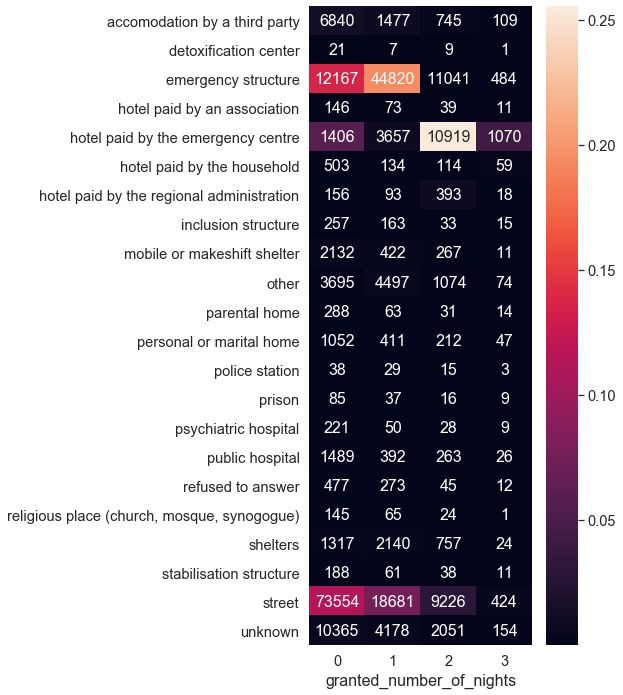

In [253]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_train)

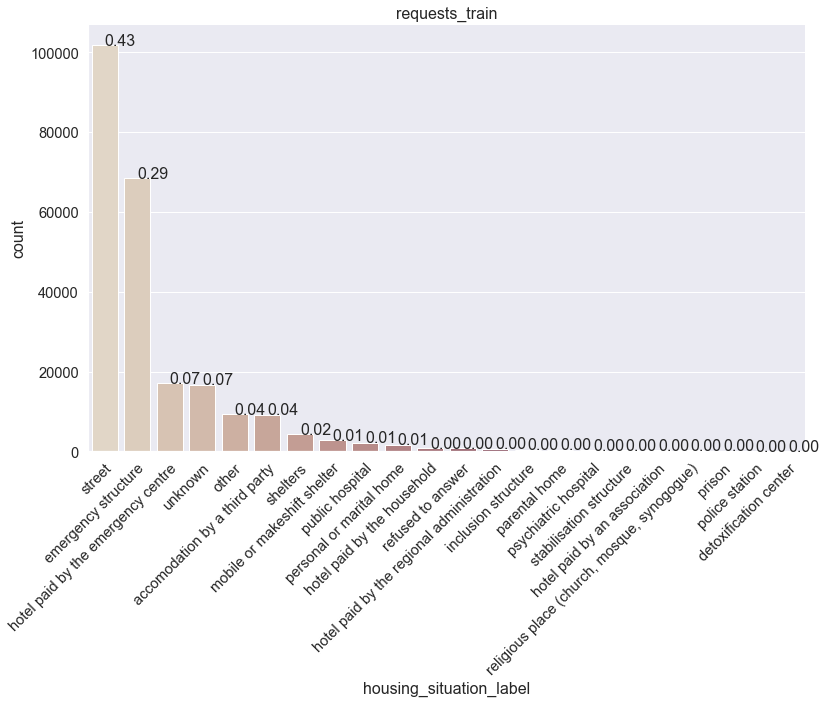

In [167]:
plot_hist_cat(x="housing_situation_label", data=requests_train, 
              title="requests_train")

In [168]:
requests_test.loc[requests_test["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [169]:
requests_test[requests_test["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type


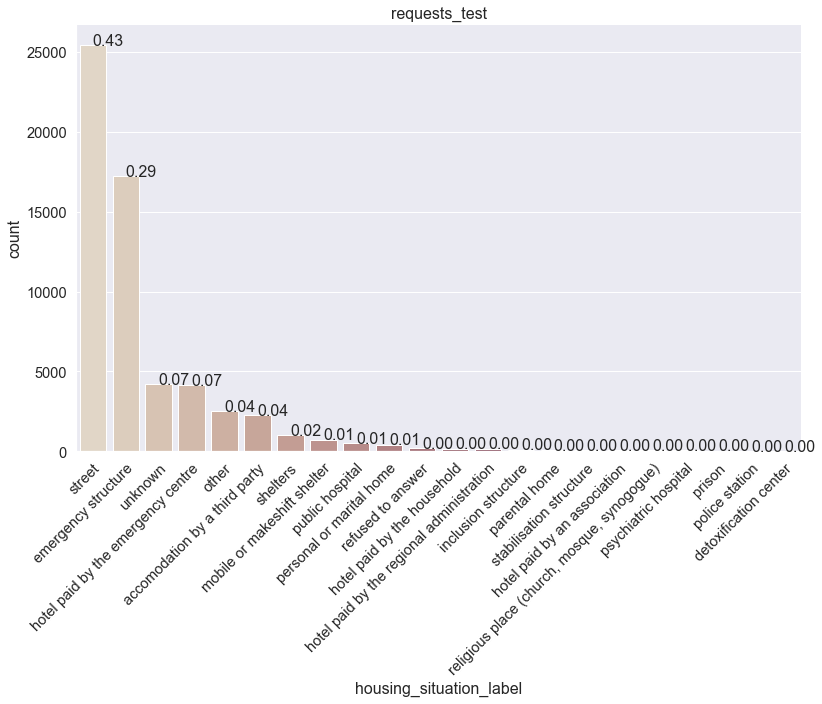

In [170]:
plot_hist_cat(x="housing_situation_label", data=requests_test, 
              title="requests_test")

In [240]:
requests_train["housing_situation_label"].nunique()

22

In [241]:
requests_test["housing_situation_label"].nunique()

22

In [242]:
requests_train["housing_situation_label"].unique()

array(['other', 'street', 'unknown', 'hotel paid by the emergency centre',
       'emergency structure', 'accomodation by a third party',
       'personal or marital home', 'parental home',
       'mobile or makeshift shelter', 'hotel paid by the household',
       'hotel paid by an association', 'stabilisation structure',
       'psychiatric hospital', 'shelters',
       'hotel paid by the regional administration', 'public hospital',
       'refused to answer', 'prison', 'inclusion structure',
       'religious place (church, mosque, synogogue)', 'police station',
       'detoxification center'], dtype=object)

In [243]:
requests_test["housing_situation_label"].unique()

array(['street', 'public hospital', 'emergency structure', 'unknown',
       'hotel paid by the household', 'accomodation by a third party',
       'hotel paid by the emergency centre', 'other', 'shelters',
       'personal or marital home', 'stabilisation structure',
       'hotel paid by the regional administration',
       'hotel paid by an association', 'inclusion structure',
       'mobile or makeshift shelter', 'prison', 'detoxification center',
       'refused to answer', 'parental home',
       'religious place (church, mosque, synogogue)', 'police station',
       'psychiatric hospital'], dtype=object)

Check if same ensemble of labels in Test and Train : 

In [244]:
print('Colonnes dans Train et pas dans Test : ')
set(requests_train["housing_situation_label"].unique().tolist()) \
    .difference(requests_test["housing_situation_label"].unique().tolist())

Colonnes dans Train et pas dans Test : 


set()

In [245]:
print('Colonnes dans Test et pas dans Train : ')
set(requests_test["housing_situation_label"].unique().tolist()) \
    .difference(requests_train["housing_situation_label"].unique().tolist())

Colonnes dans Test et pas dans Train : 


set()

=> OK same

Check if one individual of a group can represent the housing situation of group : 

For that, check if there is only 1 housing_situation_2_id for all individuals linked to 1 request into individuals_train & individuals_test.

In [252]:
individuals_train["housing_situation_2_id"].nunique()

28

In [178]:
individuals_train["housing_situation_2_id"].value_counts(dropna=False)

20    289870
35     39716
32     14872
47     14479
29      6694
44      6449
22      2599
36      2413
30      1602
34      1332
26       953
37       494
23       437
38       365
28       280
42       271
27       243
21       236
31       223
46       173
45       146
40        89
33        81
25        46
43        32
39        21
24        15
41         2
Name: housing_situation_2_id, dtype: int64

In [180]:
individuals_train["housing_situation_2_label"].value_counts(dropna=False)

on the street                                      289870
hotel paid by the emergency structure               39716
emergency accomodation                              14872
day center, social services, associations           14479
accomodated by friends or other                      6694
other                                                6449
reception center for asylum seeker                   2599
public instition (hospital, retirement home)         2413
accomodated by family                                1602
hotel not paid by an emergency structure             1332
winter plan center                                    953
private housing rental                                494
emergency accomodation centre for asylum seeker       437
public housing rental                                 365
residential roaming                                   280
child care                                            271
medical centre                                        243
emergency cent

In [208]:
individuals_train["request_id"].nunique()

238191

In [209]:
individuals_train.shape[0]

384133

In [ ]:
def fun_check_unique(id_curr):
    list_id = individuals_train[individuals_train["request_id"] == \
                         id_curr]["housing_situation_2_id"].values
    return np.all(list_id == list_id[0])
#requests_train["flag_unique_hs"] = \
#    requests_train["request_id"].apply(fun_check_unique)

In [222]:
def fun_nunique(serie_in):
    return serie_in.nunique()

pt_req_hs_nb = pd.pivot_table(individuals_train, 
                              values='housing_situation_2_id', 
               index=['request_id'], aggfunc=fun_nunique)
pt_req_hs_nb

,housing_situation_2_id
request_id,
0000602749161524aedd04269957e5fc,1
0000c66f6bb24e930cba6a3872d3ab02,1
0000dbd253c096eab97cab0545915ab2,1
0001826bdd626262ec2bda3a1b908aac,1
0001925b4cd4d65110638ee3d5f2f454,1
...,...
fffd7c7c22a9147bc4af4b869eb97f19,1
fffeeac2155c826f0ccc2f912c1049f9,1
fffeff160a0bf8c160c9e63436273cec,1


In [223]:
pt_req_hs_nb["housing_situation_2_id"].value_counts()

1    238191
Name: housing_situation_2_id, dtype: int64

In [224]:
pt_req_hs_nb_test = pd.pivot_table(individuals_test, 
                              values='housing_situation_2_id', 
                              index=['request_id'], 
                              aggfunc=fun_nunique)
pt_req_hs_nb_test

,housing_situation_2_id
request_id,
00025115a1823cf8dc4e405fac55aa08,1
000329aa7e358635d26ff2d82a3f51d9,1
00035ca76ed77fd146fbd433fdccd8a5,1
0004db4b2bf9997bbd68d59c5c4d65a5,1
00072464a3949529d9093a7622806527,1
...,...
fffd6850c8daf68dcdf737647952f40d,1
fffe858cbae1fcf6093a9676d81119d9,1
fffec8a1dff845182d68e56ed8329a37,1


In [225]:
pt_req_hs_nb_test["housing_situation_2_id"].value_counts()

1    59548
Name: housing_situation_2_id, dtype: int64

=> Every request in individual tables have only one housing_situation

We can use it directly to add data into request table (for missing values)

We can also add a data column (feature) with these information for future use

Create table to link request id with one unique housing_situation_2_id : 

In [229]:
def fun_first(serie_in):
    return serie_in.values[0]

pt_req_hs_train = pd.pivot_table(individuals_train, 
                                 values='housing_situation_2_label', 
                                 index=['request_id'], aggfunc=fun_first)

pt_req_hs_test = pd.pivot_table(individuals_test, 
                                 values='housing_situation_2_label', 
                                 index=['request_id'], aggfunc=fun_first)
pt_req_hs_train

,housing_situation_2_label
request_id,
0000602749161524aedd04269957e5fc,on the street
0000c66f6bb24e930cba6a3872d3ab02,on the street
0000dbd253c096eab97cab0545915ab2,on the street
0001826bdd626262ec2bda3a1b908aac,on the street
0001925b4cd4d65110638ee3d5f2f454,on the street
...,...
fffd7c7c22a9147bc4af4b869eb97f19,on the street
fffeeac2155c826f0ccc2f912c1049f9,on the street
fffeff160a0bf8c160c9e63436273cec,emergency accomodation


Join this data  to request tables : 

In [236]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_hs_train, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,12cc0a18890bd4959fe42df3ae58838e,ae2d5b4dc181d29e430132f145da1556,d13a17ce36c832514fda2464e11c4a9f
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-01 21:00:00,2019-02-25 15:12:05.037,2019-02-20 09:59:20.603
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,unknown
district,85,85,59,50,93
granted_number_of_nights,1,1,1,2,2
group_composition_id,10,10,80,20,60
group_composition_label,man alone,man alone,isolated child/underage,woman alone,group with child(ren)
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-03-13 12:54:15.887,2018-10-09 14:37:29.773,2018-10-02 10:47:36.931


In [237]:
requests_train = df_test.copy()

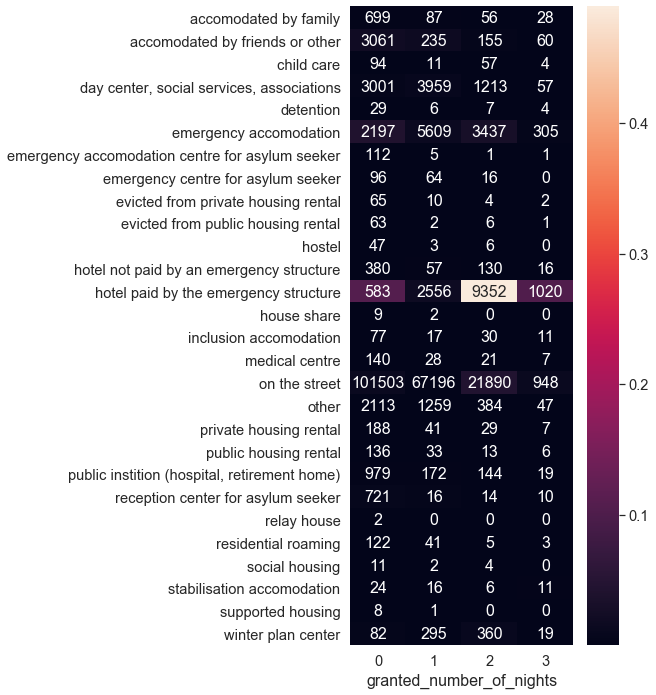

In [272]:
plot_cont(X="housing_situation_2_label",
Y="granted_number_of_nights",
data=requests_train)

In [238]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_hs_test, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,6a94e460b649033f78a6b136815364af,732820e77e68d6b8ac6da919b7c08da1,415696df2fef0b6a4d7e07b36d12dc7f,545fc3ead390446a3b08b71a44188d70,2fd26167f6d41e6422962887f42eef90
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-27 08:21:23.301,2019-02-27 15:06:56.757,2019-02-27 09:53:34.537,2019-02-27 20:19:11.887,2019-02-27 11:31:58.067
child_situation,-1,-1,-1,-1,-1
child_to_come,NaN,NaN,NaN,NaN,NaN
district,60,35,100,95,13
granted_number_of_nights,0,0,0,0,0
group_composition_id,40,10,20,10,10
group_composition_label,single mother with child(ren),man alone,woman alone,man alone,man alone
group_creation_date,2019-01-23 11:26:20.206,2019-02-25 12:20:46.138,2019-02-27 09:54:57.263,2019-01-30 17:41:20.532,2018-12-11 16:54:03.526


In [239]:
requests_test = df_test.copy()

To not add too mush dimensions to features list for model, 

we choose to correct data from requests tables by information from individuals tables

unknown and other requests housing label will be translate in requests tables existing label.

List of corresponding label if label = other :

In [258]:
requests_train[requests_train["housing_situation_label"] == 'other'] \
    ["housing_situation_2_label"].unique().tolist()

['on the street',
 'other',
 'day center, social services, associations',
 'public instition (hospital, retirement home)',
 'public housing rental',
 'reception center for asylum seeker',
 'residential roaming',
 'emergency accomodation',
 'hotel not paid by an emergency structure',
 'evicted from private housing rental',
 'medical centre',
 'accomodated by friends or other',
 'child care',
 'emergency accomodation centre for asylum seeker',
 'detention',
 'winter plan center',
 'hotel paid by the emergency structure',
 'accomodated by family',
 'inclusion accomodation',
 'evicted from public housing rental',
 'stabilisation accomodation',
 'social housing',
 'hostel',
 'emergency centre for asylum seeker',
 'house share',
 'private housing rental']

In [259]:
requests_train["housing_situation_label"].unique().tolist()

['other',
 'street',
 'unknown',
 'hotel paid by the emergency centre',
 'emergency structure',
 'accomodation by a third party',
 'personal or marital home',
 'parental home',
 'mobile or makeshift shelter',
 'hotel paid by the household',
 'hotel paid by an association',
 'stabilisation structure',
 'psychiatric hospital',
 'shelters',
 'hotel paid by the regional administration',
 'public hospital',
 'refused to answer',
 'prison',
 'inclusion structure',
 'religious place (church, mosque, synogogue)',
 'police station',
 'detoxification center']

In [282]:
val_count = requests_train[requests_train["housing_situation_2_label"] == \
                'day center, social services, associations'] \
    ["housing_situation_label"].value_counts()
val_count

emergency structure                            3680
street                                         1431
unknown                                         920
shelters                                        761
accomodation by a third party                   388
other                                           304
hotel paid by the emergency centre              152
personal or marital home                        146
mobile or makeshift shelter                     119
public hospital                                 103
refused to answer                                50
hotel paid by the household                      34
inclusion structure                              28
parental home                                    23
hotel paid by an association                     22
stabilisation structure                          18
religious place (church, mosque, synogogue)      13
police station                                   11
hotel paid by the regional administration        10
prison      

In [286]:
val_count.index[0]

'emergency structure'

In [278]:
requests_train[requests_train["housing_situation_label"] == \
               "detoxification center"].T

,26632,29504,34466,35699,48969,67763,68094,72075,82156,88908,...,178943,185169,193902,196819,202033,215692,218317,229443,230267,235269
request_id,cd016d5d25ed25f1f96be819cf71bfc1,016d1b32e413536d7991d6ebcad6b53d,7ee1595272126e3666f7d2ae652720c5,0c737f50d3f0f52c762f4e3c157be146,9f1192e71e5ac0b90c5599c358bf55f1,31be2e5e3b1d2b09af96c2e99121b02a,e828c32baeace3bdccbedeeb6db3ccdc,8dbd18cce50b6ac2a348d386cd4b028f,20794ae1e7d86698a233d6336052e95f,1ed06956c76628bf6615feda6ee7b2ed,...,478a109a481dcfdf5e455f1c4cf4251a,d9b2690358cc9b9b4f871737b7998b06,491bad91b2edbb65c071466d6f284311,f1771999d16d92d56026be357c0f79b1,0798caaa3a6cf61994996a148f6880ee,2ef855a59810775491454205be4c0876,6a7a5e8ec4e77b104d75c5e31400b7ac,a0fbb9e1898a7f045aee7d6ef58385ab,a5c8419c1186b68fe039544e4a0fb9fb,b752eaff2246ad01791b744aea6b4467
animal_presence,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
answer_creation_date,2019-02-18 15:19:52.472,2019-02-07 21:16:09.276,2019-02-11 17:00:00,2019-02-07 10:56:43.444,2019-02-27 14:30:26.919,2019-02-14 15:05:00,2019-02-04 10:52:31.171,2019-02-06 13:03:41.969,2019-03-27 16:03:15.248,2019-03-11 12:47:16.79,...,2019-01-07 14:00:00,2019-01-13 07:52:43.349,2019-01-18 13:03:11.953,2019-01-29 09:44:12.484,2019-01-20 13:19:48.523,2019-01-14 09:32:29.606,2019-01-08 21:58:30.988,2019-01-11 14:00:00,2019-01-18 09:50:00,2019-01-03 12:15:29.179
child_situation,-1,-1,70,-1,-1,-1,10,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
child_to_come,unknown,f,f,f,unknown,unknown,unknown,unknown,f,f,...,unknown,unknown,f,unknown,f,unknown,f,unknown,f,f
district,90,95,63,43,314550,40,95,84,84,79,...,40,60,52,60,92,60,78,314550,25,61
granted_number_of_nights,0,0,2,0,0,1,0,0,0,2,...,2,0,0,1,0,0,0,2,2,0
group_composition_id,10,10,20,10,10,10,100,20,10,10,...,10,10,10,10,50,10,20,10,10,10
group_composition_label,man alone,man alone,woman alone,man alone,man alone,man alone,couple with child(ren),woman alone,man alone,man alone,...,man alone,man alone,man alone,man alone,single father with child(ren),man alone,woman alone,man alone,man alone,man alone
group_creation_date,2018-03-23 17:24:13.498,2019-02-07 21:23:29.737,2018-11-04 15:13:36.652,2019-02-07 10:57:31.934,2019-02-27 14:23:48.679,2019-01-07 20:17:57.029,2019-02-04 10:56:12.029,2019-02-06 13:04:54.433,2017-12-05 13:17:47.618,2019-01-22 11:12:52.883,...,2019-01-07 20:17:57.029,2018-12-10 16:37:52.867,2018-08-01 16:37:14.931,2018-07-11 18:36:59.120,2018-11-05 19:51:29.775,2018-11-19 11:45:53.697,2018-12-31 17:57:31.711,2019-01-22 09:09:22.595,2017-09-03 00:00:00.000,2014-08-11 00:00:00.000


In [279]:
individuals_train[individuals_train["request_id"] \
                  == "cd016d5d25ed25f1f96be819cf71bfc1"].T

,42592
request_id,cd016d5d25ed25f1f96be819cf71bfc1
individual_id,689374bd45d7911e77796e86eeb8938a
housing_situation_2_id,20
housing_situation_2_label,on the street
birth_month,6
birth_year,1974
childcare_center_supervision,NaN
disabled_worker_certification,NaN
gender,male
individual_creation_date,2018-03-23


Create a dictionnary with most represented  housing_situation_label linked with housing_situation_2_label into database request : 

In [287]:
dict_conv_hs = {}
for label_curr in requests_train["housing_situation_2_label"].unique().tolist():
    val_count = requests_train[requests_train["housing_situation_2_label"] == \
                label_curr] \
        ["housing_situation_label"].value_counts()
    label_most_rep = val_count.index[0]
    dict_conv_hs[label_curr] = label_most_rep
dict_conv_hs

{'on the street': 'street',
 'hotel paid by the emergency structure': 'hotel paid by the emergency centre',
 'accomodated by friends or other': 'accomodation by a third party',
 'private housing rental': 'personal or marital home',
 'other': 'other',
 'child care': 'shelters',
 'day center, social services, associations': 'emergency structure',
 'accomodated by family': 'accomodation by a third party',
 'medical centre': 'public hospital',
 'emergency accomodation': 'emergency structure',
 'public instition (hospital, retirement home)': 'public hospital',
 'inclusion accomodation': 'inclusion structure',
 'winter plan center': 'emergency structure',
 'hotel not paid by an emergency structure': 'hotel paid by the household',
 'public housing rental': 'personal or marital home',
 'reception center for asylum seeker': 'shelters',
 'residential roaming': 'accomodation by a third party',
 'supported housing': 'personal or marital home',
 'emergency centre for asylum seeker': 'street',
 'hos

In [297]:
def fun_conv_hs(str_in):
    try:
        if str_in in dict_conv_hs.keys():
            return dict_conv_hs[str_in]
        else:
            return str_in
    except: 
        
       #print(str_in, " not found !")
        return str_in

df_test = requests_train.copy()

bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'

print("Nb. other/unknown labels before : ", 
      df_test[bol_other | bol_unknown].shape[0])
# apply conversion label from other unknow with dict
df_test.loc[bol_other | bol_unknown, 
        "housing_situation_label"] = \
    df_test[bol_other | bol_unknown] \
        ["housing_situation_2_label"].apply(fun_conv_hs)
# check 
bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'
print("Nb. other/unknown labels after : ", 
      df_test[bol_other | bol_unknown].shape[0])

Nb. other/unknown labels before :  26088
Nb. other/unknown labels after :  2065


In [302]:
requests_train = df_test.copy()

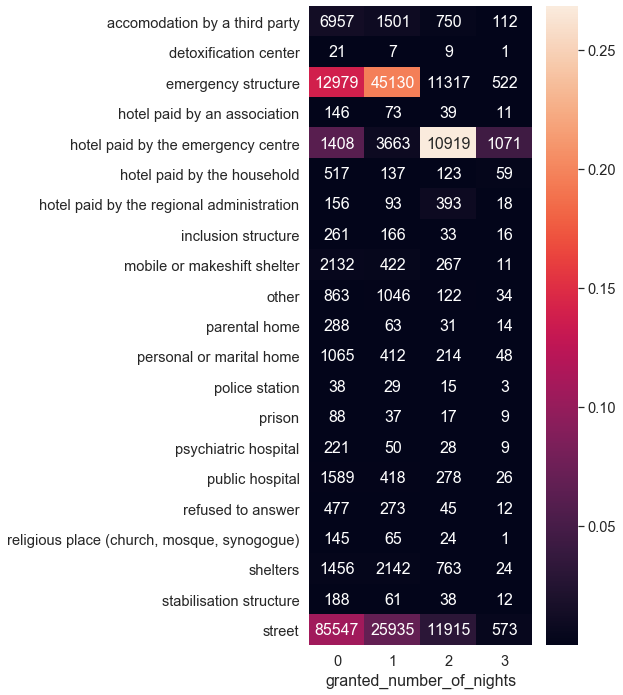

In [303]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_train)

Finally, unknown can be convert in other because not a lot of impact :

In [304]:
bol_unknown = requests_train["housing_situation_label"] == 'unknown'
requests_train.loc[bol_unknown, "housing_situation_label"] = "other"

For Test database :

In [306]:
df_test = requests_test.copy()

bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'

print("Nb. other/unknown labels before : ", 
      df_test[bol_other | bol_unknown].shape[0])
# apply conversion label from other unknow with dict
df_test.loc[bol_other | bol_unknown, 
        "housing_situation_label"] = \
    df_test[bol_other | bol_unknown] \
        ["housing_situation_2_label"].apply(fun_conv_hs)
# check 
bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'
print("Nb. other/unknown labels after : ", 
      df_test[bol_other | bol_unknown].shape[0])

Nb. other/unknown labels before :  6692
Nb. other/unknown labels after :  532


In [307]:
requests_test = df_test.copy()

In [308]:
bol_unknown = requests_test["housing_situation_label"] == 'unknown'
print("Nb. unknown before : ", requests_test[bol_unknown].shape[0])
requests_test.loc[bol_unknown, "housing_situation_label"] = "other"
bol_unknown = requests_test["housing_situation_label"] == 'unknown'
print("Nb. unknown after : ", requests_test[bol_unknown].shape[0])

Nb. unknown before :  0
Nb. unknown after :  0


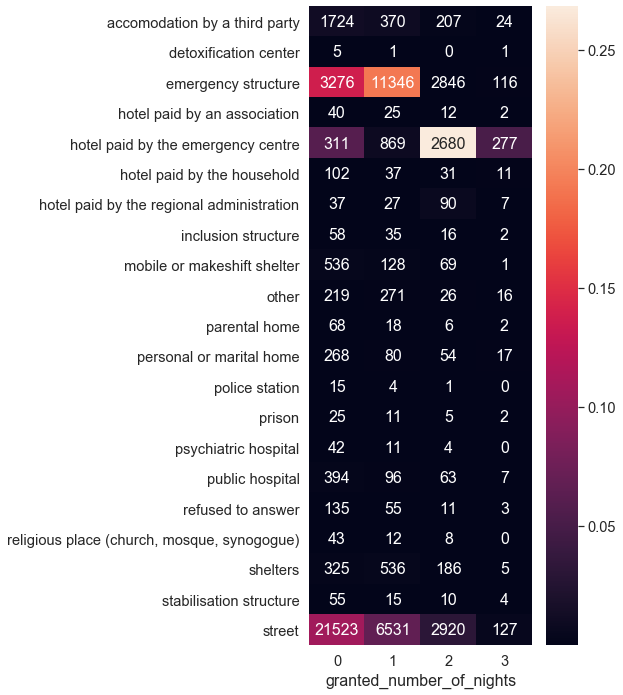

In [309]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_test)

In [310]:
# check in no Nan
bol_nan = requests_train["housing_situation_label"].isna()
print("TRAIN : Nb. nan values = ", requests_train[bol_nan].shape[0])
bol_nan = requests_test["housing_situation_label"].isna()
print("TRAIN : Nb. nan values = ", requests_test[bol_nan].shape[0])

TRAIN : Nb. nan values =  0
TRAIN : Nb. nan values =  0


=> OK cleaning done.

### child to come

In [174]:
requests_train["child_to_come"].value_counts(dropna=False)

NaN    145947
f       85878
t        6366
Name: child_to_come, dtype: int64

In [175]:
requests_train.loc[requests_train["child_to_come"].isna(),
                   "child_to_come"] = "unknown"

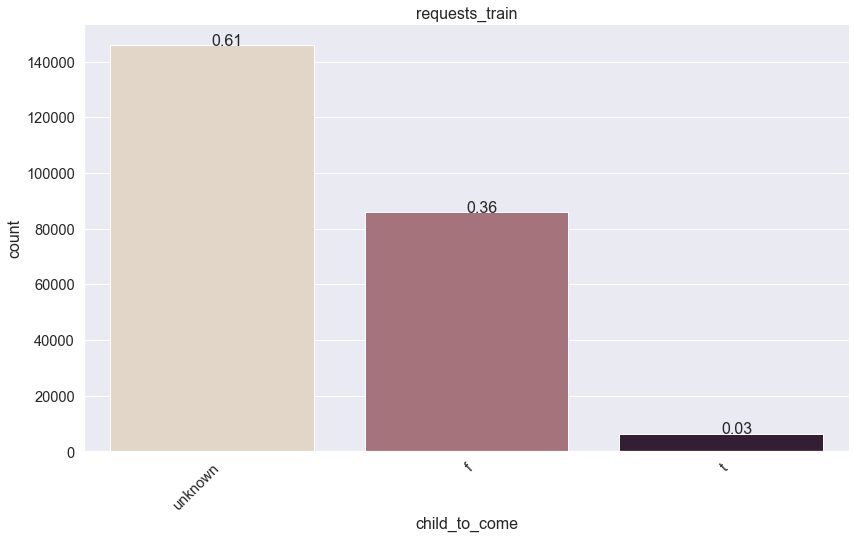

In [176]:
plot_hist_cat(x="child_to_come", data=requests_train, 
              title="requests_train")

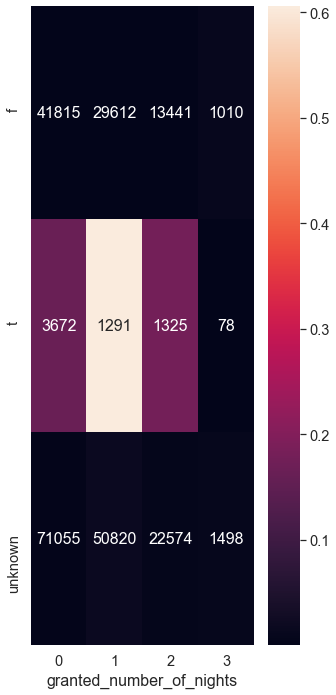

In [177]:
plot_cont(X="child_to_come", Y="granted_number_of_nights", data=requests_train)

=> dependency when True.

Find info in individuals tables : 

In [312]:
individuals_train["pregnancy"].value_counts(dropna=False)

f      372930
t       11189
NaN        14
Name: pregnancy, dtype: int64

In [313]:
def fun_pregnancy(serie_in):
    if ("t" in serie_in.tolist()):
        return "t"
    else:
        return "f"


pt_req_preg_train = pd.pivot_table(individuals_train, 
                              values='pregnancy', 
               index=['request_id'], aggfunc=fun_pregnancy)

pt_req_preg_train

,pregnancy
request_id,
0000602749161524aedd04269957e5fc,f
0000c66f6bb24e930cba6a3872d3ab02,f
0000dbd253c096eab97cab0545915ab2,f
0001826bdd626262ec2bda3a1b908aac,f
0001925b4cd4d65110638ee3d5f2f454,f
...,...
fffd7c7c22a9147bc4af4b869eb97f19,f
fffeeac2155c826f0ccc2f912c1049f9,f
fffeff160a0bf8c160c9e63436273cec,f


In [314]:
pt_req_preg_train["pregnancy"].value_counts(dropna=False)

f    227012
t     11179
Name: pregnancy, dtype: int64

Same for Test :

In [315]:
individuals_test["pregnancy"].value_counts(dropna=False)

f      92839
t       2798
NaN        4
Name: pregnancy, dtype: int64

In [316]:
pt_req_preg_test = pd.pivot_table(individuals_test, 
                              values='pregnancy', 
               index=['request_id'], aggfunc=fun_pregnancy)

pt_req_preg_test

,pregnancy
request_id,
00025115a1823cf8dc4e405fac55aa08,f
000329aa7e358635d26ff2d82a3f51d9,f
00035ca76ed77fd146fbd433fdccd8a5,f
0004db4b2bf9997bbd68d59c5c4d65a5,f
00072464a3949529d9093a7622806527,f
...,...
fffd6850c8daf68dcdf737647952f40d,f
fffe858cbae1fcf6093a9676d81119d9,t
fffec8a1dff845182d68e56ed8329a37,f


Add data to request tables

In [317]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_preg_train, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,12cc0a18890bd4959fe42df3ae58838e,ae2d5b4dc181d29e430132f145da1556,d13a17ce36c832514fda2464e11c4a9f
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-01 21:00:00,2019-02-25 15:12:05.037,2019-02-20 09:59:20.603
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,unknown
district,85,85,59,50,93
granted_number_of_nights,1,1,1,2,2
group_composition_id,10,10,80,20,60
group_composition_label,man alone,man alone,isolated child/underage,woman alone,group with child(ren)
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-03-13 12:54:15.887,2018-10-09 14:37:29.773,2018-10-02 10:47:36.931


In [318]:
requests_train = df_test.copy()

In [319]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_preg_test, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,6a94e460b649033f78a6b136815364af,732820e77e68d6b8ac6da919b7c08da1,415696df2fef0b6a4d7e07b36d12dc7f,545fc3ead390446a3b08b71a44188d70,2fd26167f6d41e6422962887f42eef90
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-27 08:21:23.301,2019-02-27 15:06:56.757,2019-02-27 09:53:34.537,2019-02-27 20:19:11.887,2019-02-27 11:31:58.067
child_situation,-1,-1,-1,-1,-1
child_to_come,NaN,NaN,NaN,NaN,NaN
district,60,35,100,95,13
granted_number_of_nights,0,0,0,0,0
group_composition_id,40,10,20,10,10
group_composition_label,single mother with child(ren),man alone,woman alone,man alone,man alone
group_creation_date,2019-01-23 11:26:20.206,2019-02-25 12:20:46.138,2019-02-27 09:54:57.263,2019-01-30 17:41:20.532,2018-12-11 16:54:03.526


In [320]:
requests_test = df_test.copy()

Check validity : 

if pregnancy True, child_to_come True ?

In [333]:
requests_train[requests_train["pregnancy"] == 't'] \
    ["child_to_come"].value_counts()

unknown    5375
t          4414
f          1390
Name: child_to_come, dtype: int64

In [335]:
requests_train[requests_train["pregnancy"] == 'f'] \
    ["child_to_come"].value_counts()

unknown    140572
f           84488
t            1952
Name: child_to_come, dtype: int64

In [338]:
requests_train[requests_train["child_to_come"] == 't'] \
    ["pregnancy"].value_counts()

t    4414
f    1952
Name: pregnancy, dtype: int64

In [339]:
requests_train[requests_train["child_to_come"] == 'f'] \
    ["pregnancy"].value_counts()

f    84488
t     1390
Name: pregnancy, dtype: int64

In [342]:
requests_train[requests_train["child_to_come"] == 'unknown'] \
    ["pregnancy"].value_counts()

f    140572
t      5375
Name: pregnancy, dtype: int64

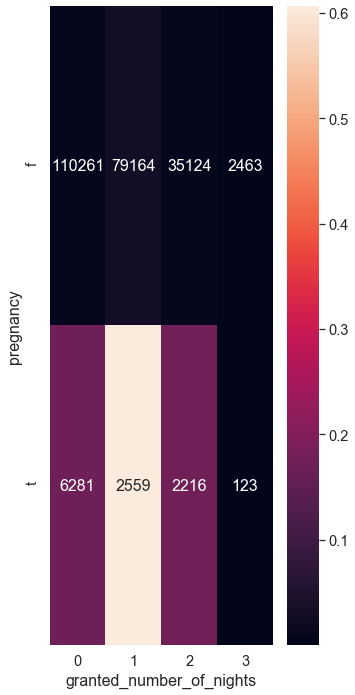

In [343]:
plot_cont(X="pregnancy", Y="granted_number_of_nights", data=requests_train)

=> We can take "pregnancy" as feature because less nan values and keep information
(altough data "child_to_come" is not exactly the same as pregnancy)